# Semantic Search with S-BERT is all you need - Subir Verma
https://medium.com/mlearning-ai/semantic-search-with-s-bert-is-all-you-need-951bc710e160

We want to build a search bar for users to search for movies and for simplicity let us consider we want to search in the movie plot field only. Users are allowed to type in some keywords or sentence which can describe their movie and we bring the best we can by closely understanding the Query and Movie plots.

In [22]:
# import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# import data from downloads folder
df = pd.read_csv('C:/Users/Jason/Downloads/wiki_movie_plots_deduped.csv')
df['doc_len'] = df['Plot'].apply(lambda words: len(words.split()))

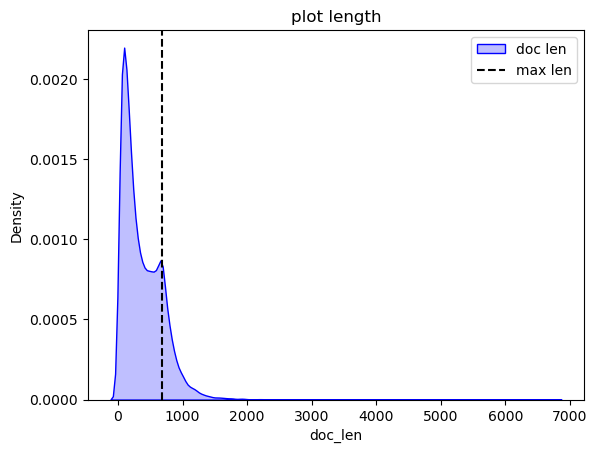

In [19]:
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.kdeplot(df['doc_len'], color='b', label='doc len', fill=True)
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [23]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

c:\Users\Jason\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# import faiss
encoded_data = model.encode(df.Plot.tolist())   # TOO SLOW
# encoded_data = np.asarray(encoded_data.astype('float32'))
# index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
# index.add_with_ids(encoded_data, np.array(range(0, len(df))))
# faiss.write_index(index, 'movie_plot.index')

KeyboardInterrupt: 

In [ ]:
def fetch_movie_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = dict()
    meta_dict['Title'] = info['Title']
    meta_dict['Plot'] = info['Plot'][:500]
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [ ]:
from pprint import pprint
query="Artificial Intelligence based action movie"
results=search(query, top_k=5, index=index, model=model)
print("\n")
for result in results:
    print('\t',result)

## Finetuning (transer learning) the Sentence-BERT model
synthetic query generation

In [ ]:
# Parameters for generation
batch_size = 16 #Batch size
num_queries = 5 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 64   #Max length for output query
def _removeNonAscii(s): return "".join(i for i in s if ord(i) < 128)
with open('generated_queries_all.tsv', 'w') as fOut:
    for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
        sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
        inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
        outputs = model.generate(
            **inputs,
            max_length=max_length_query,
            do_sample=True,
            top_p=0.95,
            num_return_sequences=num_queries)

        for idx, out in enumerate(outputs):
            query = tokenizer.decode(out, skip_special_tokens=True)
            query = _removeNonAscii(query)
            para = sub_paragraphs[int(idx/num_queries)]
            para = _removeNonAscii(para)
            fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

In [ ]:
# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])

In [ ]:
# MultipleNegativeRankingLoss

from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os

train_examples = [] 
with open('../input/user-query-data/generated_queries_all (1).tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)
# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)